In [112]:
import pandas
#pandas.options.display.max_colwidth = None #set_option('max_colwidth', None)
#pandas.options.display.max_columns = 20#None#(100)#set_option('max_columns', None)

import numpy
import pygsheets
import datetime
#import scipy
#import sklearn.linear_model
#import sklearn.cluster
import re

import matplotlib.pyplot as mp

# import pipelines dataset

In [113]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')

spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
#spreadsheet = gc.open_by_key('1PKsCoVnfnCEalDBOF0Fmny0-pg1qy86DoReNHI-97WM') # version from 6 March 2023 for EGT report

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
oil_pipes = oil_pipes.drop('WKTFormat', axis=1)
pipes_df_orig = gas_pipes.copy()

# remove empty cells for pipes, owners
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.PipelineName!='']
#pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Wiki!='']
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Fuel.isin(['Gas','Hydrogen'])]

#get other relevant sheets
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']
parents_df.set_index('Parent', inplace=True)

In [114]:
country_ratios_df.replace('--', numpy.nan, inplace=True)
pipes_df_orig.replace('--',numpy.nan,inplace=True)
pipes_df_orig['ProposalYear'] = pipes_df_orig['ProposalYear'].replace('',numpy.nan)
pipes_df_orig['H2Repurposed%'] = pipes_df_orig['H2Repurposed%'].replace('',numpy.nan)
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [115]:
# region_df_eu = region_df_orig.copy()[region_df_orig['EuropeanUnion']=='Yes']
region_df_egt = region_df_orig.copy()[region_df_orig['EuroGasTracker']=='Yes']
# region_df_europe = region_df_orig.copy()[region_df_orig['Region']=='Europe']
# region_df_eu_uk = region_df_orig.copy()[(region_df_orig['Region']=='Europe') | 
#                                           (region_df_orig['Country'].isin(['United Kingdom','Israel']))]

In [116]:
region_df_touse = region_df_egt.copy()

In [117]:
# subset the pipelines to use
# can't use pipes_df_touse... because some of the pipelines get eliminated if they're not in the same country...
pipes_df_touse = pipes_df_orig.loc[
    ~pipes_df_orig['Countries'].apply(
        lambda x: set(x.split(', ')).isdisjoint(set(region_df_touse['Country'].tolist()))
    )]

pipes_df_touse_h2 = pipes_df_touse.loc[(pipes_df_touse.Fuel=='Hydrogen')&
                                        (pipes_df_touse.EuroGasTracker=='yes')]
pipes_df_touse = pipes_df_touse.loc[pipes_df_touse.Fuel=='Gas']
pipes_df_orig_gas = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')]
country_ratios_df_gas = country_ratios_df.loc[#(country_ratios_df.Country.isin(region_df_touse['Country'].tolist()))&
                                                (country_ratios_df.Fuel=='Gas')]

# country_ratios_df_gas_europe = country_ratios_df.loc[(country_ratios_df.Country.isin(region_df_touse['Country'].tolist()))&
#                                                 (country_ratios_df.Fuel=='Gas')]

# cost estimates for Europe

### correct Poland-Ukraine Interconnector

In [118]:
# https://www.gem.wiki/Poland-Ukraine_Interconnector_Gas_Pipeline
# our country_ratios code calculates this is half in each country, but it's not
country_ratios_df_gas.loc[(country_ratios_df_gas.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_gas.Country=='Poland'),'MergedKmByCountry'] = 1.5

country_ratios_df_gas.loc[(country_ratios_df_gas.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_gas.Country=='Ukraine'),'MergedKmByCountry'] = 99.0

### correct Gas Interconnection Poland-Lithuania (our fractional calc doesn't get it right)

In [119]:
country_ratios_df_gas.loc[(country_ratios_df_gas.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_gas.Country=='Poland'),'MergedKmByCountry'] = 343.0

country_ratios_df_gas.loc[(country_ratios_df_gas.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_gas.Country=='Lithuania'),'MergedKmByCountry'] = 165.0

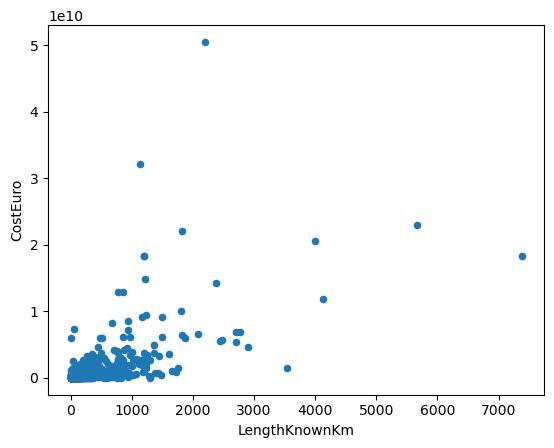

In [120]:
ax = pipes_df_orig.plot.scatter('LengthKnownKm','CostEuro')

## cost decision!

in the 2024 EGT report, I'm using the cost calculations from the most recent pipelines and terminals reports

pipelines here:  
https://docs.google.com/spreadsheets/d/1vb9-yPbfW7h8je6hxD0NdUaZb4jpIT4xOYpeCnhePs8/edit#gid=259015665

terminals here:  
https://docs.google.com/spreadsheets/d/1vdwrxwR0k8kwDrwneRsNchDNQ96U5D3cO8BLZaAb15o/edit#gid=462850940

In [121]:
mean_cost_per_km = 3.60726844 # million Euro per km

country_ratios_df_gas['TotalEstCostEuroMillionsHigh'] = numpy.nan

for idx,row in country_ratios_df_gas.iterrows():
    country_ratios_df_gas.loc[idx,'TotalEstCostEuroMillionsHigh'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_gas['CostEuroPerKm'].isna()
country_ratios_df_gas.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    country_ratios_df_gas[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_gas[costs_exist_TF]['MergedKmByCountry']

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_20015/4136194539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_gas['TotalEstCostEuroMillionsHigh'] = numpy.nan


In [122]:
mean_cost_per_km =  3.60726844 # million Euro per km

country_ratios_df_gas['TotalEstCostEuroMillionsLow'] = numpy.nan

for idx,row in country_ratios_df_gas.iterrows():
    country_ratios_df_gas.loc[idx,'TotalEstCostEuroMillionsLow'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_gas['CostEuro'].isna()

country_ratios_df_gas.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \
    country_ratios_df_gas[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_gas[costs_exist_TF]['MergedKmByCountry']
country_ratios_df_gas.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    country_ratios_df_gas[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_gas[costs_exist_TF]['MergedKmByCountry']

country_ratios_df_gas.loc[(country_ratios_df_gas['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_gas['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_gas['Country']=='Italy'), ['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6 * 2/3 * 0.5

country_ratios_df_gas.loc[(country_ratios_df_gas['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_gas['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_gas['Country']=='Greece'), ['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6 * 2/3 * 0.5

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_20015/325386100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_gas['TotalEstCostEuroMillionsLow'] = numpy.nan


In [123]:
country_ratios_df_gas['TotalEstCostEuroMillionsMean'] = \
    country_ratios_df_gas[['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']].mean(axis=1)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_20015/986689112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_gas['TotalEstCostEuroMillionsMean'] = \


In [124]:
output_columns = ['Country',
                  'PipelineName',
                  'SegmentName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean',
                  'TotalEstCostEuroMillionsLow',
                  'TotalEstCostEuroMillionsHigh']
country_ratios_df_gas_excel = country_ratios_df_gas[country_ratios_df_gas['Status'].isin(['Proposed','Construction'])]
country_ratios_df_gas_excel = country_ratios_df_gas.sort_values(['Status',
                                                                     'PipelineName',
                                                                     'TotalEstCostEuroMillionsLow',
                                                                     'TotalEstCostEuroMillionsHigh'],
                                                                    ascending=[True,True,False,False])
country_ratios_df_gas_excel.replace(numpy.nan, '')
country_ratios_df_gas_excel = country_ratios_df_gas_excel[output_columns]

## print export, import, and within-EU pipelines

planned pipelines to import gas into the EU

In [125]:
# get the pipelines that import into the EU, export out, and are completely within
pipes_df_eu_imports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (~pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_exports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (~pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_within = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

## Table A2 all of Europe - import

In [126]:
import_projectids = country_ratios_df_gas.loc[
    (country_ratios_df_gas.Status.isin(['Proposed','Construction']))&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))&
    ((~country_ratios_df_gas.StartCountry.isin(region_df_touse.Country.tolist()))&
    (country_ratios_df_gas.EndCountry.isin(region_df_touse.Country.tolist())))].ProjectID.tolist()

# all_other_projectids = list(set(country_ratios_df_gas.loc[
#     country_ratios_df_gas.Status.isin(['Proposed','Construction'])].ProjectID) - set(import_projectids))

all_other_projectids = country_ratios_df_gas.loc[
    (country_ratios_df_gas.Status.isin(['Proposed','Construction']))&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))&
    (~country_ratios_df_gas.ProjectID.isin(import_projectids))].ProjectID.tolist()

country_ratios_df_gas_europe_only = country_ratios_df_gas.loc[
    (country_ratios_df_gas.Status.isin(['Proposed','Construction']))&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))]

output_columns = ['Country',
                  'PipelineName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean',]
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

country_ratios_df_gas_europe_only.loc[(country_ratios_df_gas_europe_only.ProjectID.isin(import_projectids))&
                            (country_ratios_df_gas_europe_only.Country.isin(region_df_touse.Country.tolist()))
                            ].sort_values(['Status','PipelineName','TotalEstCostEuroMillionsLow'], 
                                          ascending=[True,True,False])[output_columns].replace(numpy.nan,'').style.hide(axis='index')


Country,PipelineName,Status,CapacityBcm/y,MergedKmByCountry,TotalEstCostEuroMillionsMean
Ukraine,Taganrog-Melitopol-Berdyansk Gas Pipeline,Construction,,220.570000,795.655200
Türkiye,Arab Gas Pipeline,Proposed,,9.850000,35.531594
Spain,Nigeria-Morocco Gas Pipeline,Proposed,30.000000,137.850000,558.603754
Türkiye,Trans-Anatolian Gas Pipeline,Proposed,7.000000,0.000000,0.000000
Greece,Trans-Anatolian Gas Pipeline,Proposed,7.000000,0.000000,0.000000
Türkiye,Trans-Anatolian Gas Pipeline,Proposed,9.000000,0.000000,0.000000
Greece,Trans-Anatolian Gas Pipeline,Proposed,9.000000,0.000000,0.000000


## table A2 (Rob's summation)

## Table A3 (appendix)

### longer than 150 km

In [127]:
# must be longer than 150 total, and the segment must be located within the EU
projectids_threshold = list(
    set(country_ratios_df_gas.loc[(country_ratios_df_gas.MergedKmByPipeline>150)&
                                   (country_ratios_df_gas.ProjectID.isin(all_other_projectids))]['ProjectID'])
)

projectids_under_threshold = list(
    set(all_other_projectids) - set(projectids_threshold)
)

projectids_threshold.__len__()

30

In [128]:
projectids_under_threshold.__len__()

109

In [129]:
import_projectids.__len__()

7

In [130]:
all_other_projectids.__len__()

181

In [131]:
output_columns = ['Country',
                  'PipelineName',
                  #'Status',
                  'CapacityBcm/y',
                  'MergedKmByPipeline',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean']#,
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

# country_ratios_df_gas.loc[
#     (country_ratios_df_gas.ProjectID.isin(import_projectids+all_other_projectids))&
#     (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))
#     ].groupby('Country')['MergedKmByCountry'].sum()

country_ratios_df_gas.replace(numpy.nan,'').loc[
    (country_ratios_df_gas.ProjectID.isin(import_projectids+all_other_projectids))&
    (country_ratios_df_gas.MergedKmByPipeline>150)&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))
    ].sort_values([
    'Status','PipelineName','TotalEstCostEuroMillionsLow'], ascending=[True,True,False])[output_columns].style.hide(axis='index')


Country,PipelineName,CapacityBcm/y,MergedKmByPipeline,MergedKmByCountry,TotalEstCostEuroMillionsMean
Poland,Gustorzyn-Wronów Gas Pipeline,,308.000000,308.000000,1111.038680
Italy,Methanization of Sardinia Project,,573.000000,573.000000,600.000001
Poland,Pogórska-Wola-Tworzen Gas Pipeline,,168.000000,168.000000,300.500001
Ukraine,Taganrog-Melitopol-Berdyansk Gas Pipeline,,272.740000,220.570000,795.655200
Italy,Adriatica Pipeline,8.800000,170.000000,170.000000,553.600000
Albania,Albania–Kosovo Gas Pipeline,,212.000000,107.410000,108.929952
Serbia,Albania–Kosovo Gas Pipeline,,212.000000,104.590000,106.070047
Lithuania,Amber Grid Gas Transmission System,,286.820000,286.820000,1034.636734
Türkiye,Arab Gas Pipeline,,310.000000,9.850000,35.531594
Norway,Barents Sea Pipeline,,195.000000,195.000000,352.293577


### shorter than 150 km

In [132]:
# below_threshold_df = country_ratios_df_gas_europe_only.loc[(country_ratios_df_gas_europe_only.ProjectID.isin(projectids_under_threshold))&
#                                                  (country_ratios_df_gas_europe_only.Country.isin(region_df_touse.Country))]#.groupby('Status')

below_threshold_df = country_ratios_df_gas.loc[
    (country_ratios_df_gas.ProjectID.isin(import_projectids+all_other_projectids))&
    (country_ratios_df_gas.MergedKmByPipeline<=150)&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))
    ]#.sort_values([
    #'Status','PipelineName','TotalEstCostEuroMillionsLow'], ascending=[True,True,False])[output_columns].style.hide(axis='index')

below_threshold_df.groupby('Status')[['MergedKmByCountry',
                                      'TotalEstCostEuroMillionsMean',
                                      'TotalEstCostEuroMillionsLow',
                                      'TotalEstCostEuroMillionsHigh']].sum()

,MergedKmByCountry,TotalEstCostEuroMillionsMean,TotalEstCostEuroMillionsLow,TotalEstCostEuroMillionsHigh
Status,,,,
Construction,608.62,1111.062977,1111.062977,1111.062977
Proposed,5309.56,12902.917432,12902.917432,12902.917432


# import terminals now

In [133]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')
#spreadsheet = gc.open_by_key('1BHiidrJnzh96Em3KrqBpCoWaJ3GB5OeCY9dHVaEDEFs') # mar 22 2022 version for EGT
#spreadsheet = gc.open_by_key('1d0kLE0WmAn9b4XdugffiEaAHGWy6EhyF7zY1DM12zCc') # 1 Mar 2023 version for EGT report

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A3')

In [134]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# only keep LNG terminals (remove oil)
terms_df_orig = terms_df_orig.loc[terms_df_orig.Fuel=='LNG']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig.Wiki!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig.Status!='']

In [135]:
terms_df_touse = terms_df_orig.loc[(terms_df_orig['Country'].isin(region_df_touse.Country.tolist()))&
                                   (terms_df_orig.Fuel=='LNG')]
terms_df_touse_imports = terms_df_touse.loc[(terms_df_orig['Country'].isin(region_df_touse['Country']))&
                                            (terms_df_touse['FacilityType']=='Import')]

In [136]:
terms_df_touse_imports.loc[terms_df_touse_imports.Status.isin(['Proposed','Construction'])].shape

(50, 98)

In [137]:
parent_metadata_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parent_metadata_df.set_index('Parent', inplace=True)

## calculate floating costs (high and low estimates)

In [138]:
mean_cost_per_bcmy_floating = 1.653105e+08/1e6 # from 2023 terminals report # ols_estimator_f.coef_[0][0]/1e6
mean_cost_per_bcmy_onshore = 4.447106e+08/1e6 # from 2023 termnals report # ols_estimator_o.coef_[0][0]/1e6

terms_df_europe_import_future = terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
                                                 (terms_df_touse['FacilityType']=='Import')]

# do for floating
terms_df_europe_import_future['TotalEstCostEuroMillionsLow'] = numpy.nan

terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']=='yes'),
                                'TotalEstCostEuroMillionsLow'] = \
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']=='yes'),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_floating

# now do for onshore
#terms_df_europe_import_future.loc[:,'TotalEstCostEuroMillionsLow'] = numpy.nan
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']==''),
                                'TotalEstCostEuroMillionsLow'] = \
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']==''),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_onshore

# then replace any that we have already
# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_europe_import_future['CostEuro'].isna()
terms_df_europe_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \
    terms_df_europe_import_future[costs_exist_TF]['CostEuro']/1e6 #*euro_multiplier/1e6

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_20015/740954265.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_europe_import_future['TotalEstCostEuroMillionsLow'] = numpy.nan


LARGER MEAN

In [139]:
mean_cost_per_bcmy_floating = 1.646520e+08/1e6 # from 2023 terminals report # terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6
mean_cost_per_bcmy_onshore = 4.447106e+08/1e6 # from 2023 termnals report # terms_df_onshore_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6

# terms_df_europe_import_future = terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
#                                                  (terms_df_touse['FacilityType']=='Import')]

# do for floating
terms_df_europe_import_future['TotalEstCostEuroMillionsHigh'] = numpy.nan

terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']=='yes'),
                                'TotalEstCostEuroMillionsHigh'] = \
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']=='yes'),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_floating

# now do for onshore
#terms_df_europe_import_future.loc[:,'TotalEstCostEuroMillionsLow'] = numpy.nan
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']==''),
                                'TotalEstCostEuroMillionsHigh'] = \
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']==''),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_onshore

# then replace any that we have already
# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_europe_import_future['CostEuro'].isna()
terms_df_europe_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    terms_df_europe_import_future[costs_exist_TF]['CostEuro']/1e6 #*euro_multiplier/1e6

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_20015/563889206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_europe_import_future['TotalEstCostEuroMillionsHigh'] = numpy.nan


In [140]:
terms_df_europe_import_future['TotalEstCostEuroMillionsMean'] = \
    terms_df_europe_import_future[['TotalEstCostEuroMillionsLow', 'TotalEstCostEuroMillionsHigh']].mean(axis=1)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_20015/409365926.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  terms_df_europe_import_future['TotalEstCostEuroMillionsMean'] = \
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_20015/409365926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_europe_import_future['TotalEstCostEuroMillionsMean'] = \


### correct outliers/special cases

In [141]:
# Zeebrugge terminal is 116 million for BOTH expansion projects, so set one equal to zero so it's not counted twice
#T042601	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2024 Expansion
#T042602	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2026 Expansion
outliers_comboids = ['T042602']
terms_df_europe_import_future.loc[
    terms_df_europe_import_future.ComboID.isin(outliers_comboids),
    ['TotalEstCostEuroMillionsMean','TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = 0.0

## remove terminal expansions (costs aren't estimated for new builds)

# Table A1

In [142]:
terms_df_europe_import_future['CapacityInBcm/y'].sum()

248.7

In [143]:
output_columns = ['Country',
                  #'TerminalName',
                  'TerminalNameUnitName',
                  #'UnitName',
                  'CapacityInBcm/y',
                  #'Status',
                  #'FacilityType',
                  'TotalEstCostEuroMillionsMean']#,
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

terms_df_europe_import_future['TerminalNameUnitName'] = (terms_df_europe_import_future.TerminalName + ' ' + terms_df_europe_import_future.UnitName).str.strip()
terms_df_europe_import_future.sort_values(['Status','TerminalNameUnitName'],
                                        ascending=[True,True])[output_columns].replace(numpy.nan,'').style.hide(axis='index')

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_20015/4201454884.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  terms_df_europe_import_future['TerminalNameUnitName'] = (terms_df_europe_import_future.TerminalName + ' ' + terms_df_europe_import_future.UnitName).str.strip()
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_20015/4201454884.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_europe_import_future['TerminalNameUnitName'] = (terms_df_europe_import_future.TerminalName + ' '

Country,TerminalNameUnitName,CapacityInBcm/y,TotalEstCostEuroMillionsMean
Greece,Alexandroupolis FSRU,5.500000,360.000000
Germany,Brunsbüttel LNG Terminal,8.000000,1300.000000
Cyprus,Cyprus LNG Terminal,2.720000,542.000000
Netherlands,Gate LNG Terminal Expansion,4.000000,350.000000
United Kingdom,Grain LNG Terminal Expansion,5.170000,200.000000
Estonia,Paldiski FSRU,,500.000000
Germany,Stade FSRU,6.000000,989.887500
Germany,Wilhelmshaven TES FSRU,5.000000,824.906250
Belgium,Zeebrugge LNG Terminal 2024 Expansion,6.390000,116.000000
Belgium,Zeebrugge LNG Terminal 2026 Expansion,1.770000,0.000000


# versus the LNG global report

In [144]:
terms_df_europe_import_future.TotalEstCostEuroMillionsMean.sum()

44434.40204138999

# table 2 - 2024 report

In [145]:
# table 1 shows country totals of pipeline length, cost, LNG capacity, cost, total cost
table2_columns = ['PipelineLengthKm','PipelineCostMillionEuro',
                  'LNGImportCapacityBcm/y','LNGTerminalCostMillionEuro','TotalCostMillionEuro']
table2_df = pandas.DataFrame(columns=table2_columns, index=region_df_touse.Country.tolist())

table2_df['PipelineLengthKm'] = country_ratios_df_gas.loc[
    (country_ratios_df_gas.ProjectID.isin(import_projectids+all_other_projectids))&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))
    ].groupby('Country')['MergedKmByCountry'].sum()

table2_df['PipelineCostMillionEuro'] = country_ratios_df_gas.loc[
    (country_ratios_df_gas.ProjectID.isin(import_projectids+all_other_projectids))&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))].groupby('Country')['TotalEstCostEuroMillionsMean'].sum()

# add half of Trans-Adriatic expansion to Italy, half to Greece
#table2_df.loc['Greece','PipelineCostMillionEuro']+=1035/2
#table2_df.loc['Italy','PipelineCostMillionEuro']+=1035/2

table2_df['LNGImportCapacityBcm/y'] = terms_df_europe_import_future.groupby('Country')['CapacityInBcm/y'].sum()
table2_df['LNGTerminalCostMillionEuro'] = terms_df_europe_import_future.groupby('Country')['TotalEstCostEuroMillionsMean'].sum()
table2_df['TotalCostMillionEuro'] = table2_df.loc[:,('PipelineCostMillionEuro','LNGTerminalCostMillionEuro')].sum(axis=1)

if 'Total' in table2_df.index:
    table2_df.drop(index='Total', inplace=True)   
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df.loc['Total'] = total

else:
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df.loc['Total'] = total

# replace NaN with ''
table2_df.replace(numpy.nan, '', inplace=True)
table2_df.replace(0.0, '', inplace=True)

In [146]:
table2_df#['LNGImportCapacityBcm/y'][:-1].replace('',numpy.nan).sum()

,PipelineLengthKm,PipelineCostMillionEuro,LNGImportCapacityBcm/y,LNGTerminalCostMillionEuro,TotalCostMillionEuro
Cyprus,921.15,2710.635336,2.72,542.0,3252.635336
Israel,246.0,706.812474,,,706.812474
Türkiye,156.13,268.60613,,,268.60613
Albania,325.55,323.264842,,,323.264842
Andorra,,,,,
Austria,59.39,214.235673,,,214.235673
Belgium,147.89,533.47893,8.16,116.0,649.47893
Bulgaria,546.57,1488.989092,,,1488.989092
Bosnia and Herzegovina,676.51,319.414059,,,319.414059
Belarus,,,,,


# creating figure 1 data

sum of Table 1 columns...

In [147]:
figure1_table_columns = ['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro','Total']
figure1_table_df = pandas.DataFrame(0, columns=figure1_table_columns, index=region_df_touse.Country,)


# for proposed
figure1_table_df['TotalProposedCostMillionEuro'] = \
country_ratios_df_gas.loc[country_ratios_df_gas.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

figure1_table_df['TotalProposedCostMillionEuro'] = \
figure1_table_df['TotalProposedCostMillionEuro'].add( \
terms_df_europe_import_future.loc[terms_df_europe_import_future.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum(), \
                                                    fill_value=0)

#figure1_table_df.loc['Italy','TotalProposedCostMillionEuro'] += 1035/2.
#figure1_table_df.loc['Greece','TotalProposedCostMillionEuro'] += 1035/2.

# for construction
figure1_table_df['TotalConstructionCostMillionEuro'] = \
country_ratios_df_gas.loc[country_ratios_df_gas.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

figure1_table_df['TotalConstructionCostMillionEuro'] = \
figure1_table_df['TotalConstructionCostMillionEuro'].add( \
terms_df_europe_import_future.loc[terms_df_europe_import_future.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum(), \
                                                         fill_value=0, axis=0)

figure1_table_df['Total'] = \
figure1_table_df[['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro']].sum(axis=1)
figure1_table_df.sort_values(['Total','Country'], ascending=[False, True], inplace=True)

figure1_table_df.replace(numpy.nan, '', inplace=True)
figure1_table_df.replace(0, '', inplace=True)

In [148]:
figure1_table_df

,TotalConstructionCostMillionEuro,TotalProposedCostMillionEuro,Total
Country,,,
Germany,3251.869951,17386.093137,20637.963088
Greece,788.079717,12624.904257,13412.983975
Italy,600.000001,10606.000078,11206.000078
Poland,2372.43094,3037.811096,5410.242036
United Kingdom,200.0,5023.289617,5223.289617
Cyprus,542.0,2710.635336,3252.635336
France,,2945.9083,2945.9083
Croatia,,2235.58963,2235.58963
Lithuania,,1971.225963,1971.225963


# owner analysis

## for pipelines

In [149]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df_gas.loc[
                            (country_ratios_df_gas.Status.isin(['Proposed','Construction']))&
                            (country_ratios_df_gas.Country.isin(region_df_touse.Country))].iterrows():

    print(row.ProjectID)
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #hq_country_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].ParentHQCountry.values[0]
    
    #if parent_string == '--':
    #    parent_string = 'unknown [unknown %]'
    
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]
    #print(percent_list)

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        #if parent not in parents_df.index.to_list():
        #    parents_df.loc[parent,'ParentHQCountry']='unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'MergedKmByCountry':row.MergedKmByCountry,
                                                                         'MergedKmByPipeline':row.MergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd,
                                                                         'TotalEstCostEuroMillionsMean':row.TotalEstCostEuroMillionsMean,
                                                                         'LengthPerCountryFraction':row.LengthPerCountryFraction}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.MergedKmByCountry
owner_parent_calculations_df['EstimatedCostEuroMillionsMeanByCountry'] = \
        owner_parent_calculations_df.FractionOwnership*\
        owner_parent_calculations_df.TotalEstCostEuroMillionsMean
        # owner_parent_calculations_df.FractionOwnership*\
        # owner_parent_calculations_df.LengthPerCountryFraction*\
        # owner_parent_calculations_df.TotalEstCostEuroMillionsMean

P0463
P0473
P0479
P0479
P0702
P0702
P0702
P0718
P0815
P0827
P0827
P0827
P1321
P1321
P1324
P1324
P1327
P1327
P1342
P1342
P1343
P1345
P1345
P1347
P1348
P1349
P1352
P1354
P1487
P1487
P1691
P1693
P1693
P1697
P1699
P1699
P1702
P1705
P1706
P1706
P1708
P1710
P1711
P1712
P1712
P1714
P1773
P1773
P2025
P2025
P2036
P2083
P2083
P2088
P2089
P2090
P2188
P2188
P2190
P2191
P2191
P2209
P2235
P2270
P2271
P2272
P2462
P2462
P2463
P2464
P2466
P2467
P2719
P2721
P2727
P2728
P3104
P3107
P3108
P3109
P3137
P3138
P3203
P3203
P3203
P3205
P3205
P3206
P3206
P3206
P3243
P3244
P3281
P3281
P3311
P3311
P3333
P3333
P3335
P3335
P3336
P3336
P3384
P3395
P3420
P3481
P3489
P3606
P3606
P3620
P3657
P3657
P3725
P3725
P3893
P3908
P3916
P3941
P3959
P4000
P4201
P4202
P4327
P4331
P4331
P4332
P4332
P4361
P4362
P4363
P4372
P4373
P4374
P4374
P4399
P4399
P4402
P4402
P4403
P4405
P4406
P4425
P4432
P4445
P4462
P4463
P4464
P4464
P4465
P5276
P5487
P5488
P5489
P5490
P5491
P5492
P5493
P5494
P5499
P5500
P5501
P5501
P5502
P5503
P5527
P5528
P552

In [150]:
pipeline_costs_df = owner_parent_calculations_df.groupby('Parent')[['EstimatedCostEuroMillionsMeanByCountry']].sum().sort_values(by='EstimatedCostEuroMillionsMeanByCountry', ascending=False)
pipeline_costs_df = pipeline_costs_df.rename(columns={'EstimatedCostEuroMillionsMeanByCountry':'Pipeline costs'})

## for terminals

In [151]:
# this cell takes the terminals data set (call it "terms_df_all", here we're using the indev terminals subset)
# and loops throw every row, breaks up the parent and % ownership strings,
# and outputs a dataframe owner_parent_calculations_df that has a bunch of different useful info related
# to parent shares, capacity, etc.
owner_parent_calculations_df = pandas.DataFrame() # empty df for storing owner/parent stuff

for idx,row in terms_df_europe_import_future.iterrows():
    parent_string = row.Parent #.values[0]
    if row.TerminalID=='T0292':
        print(parent_string)

    # the two lines below go through the parent entries in the sheet and split them,
    # recording the percents and parents in separate lists, to be dealt with later
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]

    # if there are fewer recorded percents than number of parents
    if parent_list.__len__()!=percent_list.__len__():
        # if there are no percents, make them all equal
        
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        # otherwise, get the difference and distribute the remainder equally among remaining parents
        else:
            #print(row.ComboID)
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing
            #print(numpy.array(percent_list).sum())

    # now go through each parent and associated percent ownership
    # and store it alongside the project's name along with capacity, status, region, etc.
    # this is stored inside the big dataframe owner_parent_calculations_df
    for p_idx,parent in enumerate(parent_list):
        if row.TerminalID=='T0292':
            print(parent_list)
        # this if statement should not really be used
        if parent not in parent_metadata_df.index.to_list():
            print(parent, " doesn't exist as a parent")
            parent_metadata_df.loc[parent,'ParentHQCountry']='unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ComboID':row.ComboID,
                                                                         'TerminalID':row.TerminalID,
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'PercentString':'{:.2f}%'.format(percent_list[p_idx]*100),
                                                                         'ParentHQCountry':parent_metadata_df.loc[parent_metadata_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'ParentHQRegion':parent_metadata_df.loc[parent_metadata_df.index==parent]['ParentHQRegion'].values[0],
                                                                         'TerminalCountry':row.Country,
                                                                         'TerminalRegion':row.Region,
                                                                         'Status':row.Status,
                                                                         'FacilityType':row['FacilityType'],
                                                                         'CapacityInMtpa':row.CapacityInMtpa,
                                                                         'ProjectWiki':row.Wiki,
                                                                         'ProjectName':row.TerminalName+' '+str(row.UnitName),
                                                                         'TotalEstCostEuroMillionsMean':row.TotalEstCostEuroMillionsMean}])])

owner_parent_calculations_df.reset_index(drop=True, inplace=True)
owner_parent_calculations_df['CapacityOwnedInMtpa'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.CapacityInMtpa
owner_parent_calculations_df['ParentCapacityString'] = owner_parent_calculations_df.Parent + ' (' + owner_parent_calculations_df.CapacityOwnedInMtpa.round(1).astype(str).replace('nan','unknown') + ' mtpa)'
owner_parent_calculations_df['EstimatedCostEuroMillionsMeanByOwner'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.TotalEstCostEuroMillionsMean

In [152]:
terminal_costs_df = owner_parent_calculations_df.groupby('Parent')[['EstimatedCostEuroMillionsMeanByOwner']].sum().sort_values(by='EstimatedCostEuroMillionsMeanByOwner', ascending=False)
terminal_costs_df = terminal_costs_df.rename(columns={'EstimatedCostEuroMillionsMeanByOwner':'Terminal costs'})

In [153]:
pipeline_costs_df['Terminal costs'] = numpy.nan
terminal_costs_df['Pipeline costs'] = numpy.nan

## pipelines and terminals owners together

In [154]:
pipeline_and_terminal_costs_df = terminal_costs_df.add(pipeline_costs_df, fill_value=0)

In [155]:
pipeline_and_terminal_costs_df.replace(numpy.nan,0).sum().sum()

84136.86289281781

In [156]:
pipeline_and_terminal_costs_df['Total costs'] = pipeline_and_terminal_costs_df.sum(axis=1)
#pipeline_and_terminal_costs_df = pipeline_and_terminal_costs_df.loc[~pipeline_and_terminal_costs_df.index.isin(['unknown','other'])]

# Table A5

saved out as Excel and copied/pasted, also removed the bottom zero ones

In [157]:
pipeline_and_terminal_costs_df.sort_values('Total costs', ascending=False).replace(numpy.nan, '')

,Pipeline costs,Terminal costs,Total costs
Parent,,,
Snam,6186.389395,3584.381402,9770.770797
Tree Energy Solutions,,9169.18075,9169.180750
Electricite de France,4700.000002,,4700.000002
unknown,4591.4861,,4591.486100
Gaz-System,4018.233197,,4018.233197
...,...,...,...
VNG,0.0,,0.000000
Latvenergo,,0.0,0.000000
RomGaz,,0.0,0.000000


In [158]:
pipeline_and_terminal_costs_df.sort_values('Total costs', ascending=False).replace(numpy.nan, '').to_excel('pipeline-and-terminal-owner-cost-rankings.xlsx')

In [159]:
pipeline_and_terminal_costs_df.sum(axis=0)

Pipeline costs    39702.460851
Terminal costs    44434.402041
Total costs       84136.862893
dtype: float64

# table A4

In [160]:
country_ratios_df.loc[country_ratios_df.ProjectID.isin(pipes_df_touse_h2.ProjectID.tolist())].groupby('Country')[['MergedKmByCountry']].sum()

,MergedKmByCountry
Country,
Austria,809.16
Belgium,856.38
Bulgaria,366.15
Czech Republic,747.21
Denmark,797.71
Estonia,230.30
Finland,2580.02
France,2384.49
Germany,8026.99


In [161]:
hydrogen_km_df = pandas.DataFrame(index=region_df_touse.Country.tolist())

hydrogen_km_df['6th PCI list (km)'] = country_ratios_df.loc[
    country_ratios_df.ProjectID.isin(
        pipes_df_touse_h2.loc[pipes_df_touse_h2.PCI6=='yes'].ProjectID.tolist()
    )
].groupby('Country')[['MergedKmByCountry']].sum()

hydrogen_km_df['Additional proposed (km)'] = country_ratios_df.loc[
    country_ratios_df.ProjectID.isin(
        pipes_df_touse_h2.loc[pipes_df_touse_h2.PCI6!='yes'].ProjectID.tolist()
    )
].groupby('Country')[['MergedKmByCountry']].sum()

hydrogen_km_df['Country total (km)'] = hydrogen_km_df.sum(axis=1)#.replace(0,numpy.nan)

In [163]:
hydrogen_km_df.loc[(hydrogen_km_df['Country total (km)']!=0)].drop(index='Switzerland').sort_values('Country total (km)', ascending=False).replace(numpy.nan,'')

,6th PCI list (km),Additional proposed (km),Country total (km)
Germany,4120.55,3906.44,8026.99
Spain,3068.3,78.85,3147.15
Finland,1745.31,834.71,2580.02
Italy,2297.64,147.84,2445.48
France,1519.74,864.75,2384.49
United Kingdom,,2000.00,2000.00
Sweden,1250.79,495.57,1746.36
Netherlands,1420.51,109.35,1529.86
Norway,556.51,875.52,1432.03
Portugal,515.12,796.58,1311.70


In [179]:
hydrogen_km_df.sum()

6th PCI list (km)           22393.75
Additional proposed (km)    12671.55
Country total (km)          35065.30
dtype: float64

## now calculate % repurposed?

In [175]:
# multiply merged km by % repurposed and sum
# and also tabulate unknown km

print(
    pandas.DataFrame(
        pipes_df_touse_h2.LengthMergedKm * pipes_df_touse_h2['H2Repurposed%'].str.strip('%').astype(float)/100
    ).sum().values[0], "is the km repurposed")

print(pipes_df_touse_h2.LengthMergedKm.sum(), "is the total km")

print(pipes_df_touse_h2.loc[pipes_df_touse_h2['H2Repurposed%'].isna()].LengthMergedKm.sum(), "is the length of unknown")

12736.026999999998 is the km repurposed
35422.79 is the total km
5210.0 is the length of unknown


In [190]:
35000 - (12700+5200)

17100

In [192]:
12700/35000

0.3628571428571429

In [193]:
5200/35000

0.14857142857142858

In [194]:
17500/35000

0.5

In [189]:
36+15+49

100

### now for PCI6 only

In [182]:
# multiply merged km by % repurposed and sum
# and also tabulate unknown km

print(
    pandas.DataFrame(
        pipes_df_touse_h2.loc[pipes_df_touse_h2.PCI6=='yes'].LengthMergedKm * 
        pipes_df_touse_h2.loc[pipes_df_touse_h2.PCI6=='yes']['H2Repurposed%'].str.strip('%').astype(float)/100
    ).sum().values[0], "is the km repurposed")

print(pipes_df_touse_h2.loc[pipes_df_touse_h2.PCI6=='yes'].LengthMergedKm.sum(), "is the total km")

print(pipes_df_touse_h2.loc[
      (pipes_df_touse_h2.PCI6=='yes')&
      (pipes_df_touse_h2['H2Repurposed%'].isna())].LengthMergedKm.sum(), "is the length of unknown")

5813.39 is the km repurposed
22395.89 is the total km
3807.0 is the length of unknown


In [ ]:
pipes_df_touse_h2.shape

In [ ]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Pre-construction (H2 only)']['LengthMergedKm'].sum()

* how many H2 pipelines are planning to be 100%? blended?
  * A: really, none; the Malta-Italy Gas Pipeline is actually seeming realistic-ish but has language about "up to 100%" rather than a confirmation

## hydrogen table 1

In [ ]:
country_ratios_df_gas.loc[country_ratios_df_gas.H2Status!=''].MergedKmByCountry.sort_values()

In [ ]:
# country_ratios_df_gas.loc[country_ratios_df_gas.H2Status!=''].groupby(
#     ['H2Status','Country'])[['MergedKmByCountry']].sum().sort_values('MergedKmByCountry', ascending=False)

country_ratios_df_gas.loc[country_ratios_df_gas.H2Status!=''].groupby(
    ['Country'])[['MergedKmByCountry']].sum().sort_values('MergedKmByCountry', ascending=False)

# visualize timeline

In [ ]:
terms_df_touse_imports.loc[terms_df_touse_imports.Status.isin(['Operating'])]

# IEEFA report

In [ ]:
terms_df_orig.loc[(terms_df_orig.Region=='Europe')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status=='Operating')]['CapacityInBcm/y'].sum()

In [ ]:
terms_df_orig.loc[(terms_df_orig.Region=='Europe')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))]['CapacityInBcm/y'].sum()

In [ ]:
terms_df_orig.loc[(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))]['CapacityInBcm/y'].sum()

In [ ]:
275.2+246.5

In [ ]:
275.2+154.84

# CAN webinar matches?

In [ ]:
terms_df_orig.loc[(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (terms_df_orig.StartYearEarliest.isin([2022,2023,2024]))]['CapacityInBcm/y'].sum()

In [ ]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (terms_df_orig.StartYearEarliest.isin([2022,2023,2024]))]['CapacityInBcm/y'].sum()

In [ ]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (~terms_df_orig.StartYearEarliest.isnull())]['CapacityInBcm/y'].sum()

In [ ]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))]['CapacityInBcm/y'].sum()

In [ ]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Operating']))]['CapacityInBcm/y'].sum()